In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv('../../train_s3TEQDk.csv')
test_df = pd.read_csv('../../test_mSzZ8RL.csv')
#sub_df = pd.read_csv('../../sub')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [4]:
train_df.nunique()

ID                     245725
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    135292
Is_Active                   2
Is_Lead                     2
dtype: int64

In [5]:
train_df.isna().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [6]:
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [7]:
# Mapping categorical variables

In [8]:
train_df.select_dtypes('O').columns.values

array(['Gender', 'Region_Code', 'Occupation', 'Channel_Code',
       'Credit_Product', 'Is_Active'], dtype=object)

In [9]:
train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [10]:
def add_new_features(df):
    df['credit_product_missing'] = df['Credit_Product'].isna().map({True:1, False:0})
    df['occupation_mean_balance'] = df.groupby('Occupation')['Avg_Account_Balance'].transform('mean')
    df['is_active_avg_balance'] = df.groupby('Is_Active')['Avg_Account_Balance'].transform('mean')

    df['gender_avg_balance'] = df.groupby('Gender')['Avg_Account_Balance'].transform('mean')
    df['gender_avg_age'] = df.groupby('Gender')['Age'].transform('mean')
    df['gender_and_channelcode'] = df['Gender'].astype('str') + df['Channel_Code'].astype('str')
    df['gender_and_occupation'] = df['Gender'].astype('str') + df['Occupation'].astype('str')
    df['gender_and_active'] = df['Gender'].astype('str') + df['Is_Active'].astype('str')
    
def handle_missing_values(df):
    df.Credit_Product.fillna('NA', inplace=True)
    
def categorical_to_num(df):
    # Gender
    gender = {'Male': 0, 'Female': 1}
    df.Gender = df.Gender.map(gender)
        
    # Region Code
    df.Region_Code = df.Region_Code.str[2:]
    
    # Occupation
    occupation = {'Self_Employed':1, 'Salaried':2, 'Entrepreneur':3, 'Other':4}
    df.Occupation = df.Occupation.map(occupation)
    
    # Channel_Code
    df.Channel_Code = df.Channel_Code.str[1:]
    
    # Is_Active
    is_Active = {'Yes':1, 'No':0}
    df.Is_Active = df.Is_Active.map(is_Active)
    
    # Is_Active
    credit_product = {'Yes':1, 'No':0, 'NA':3}
    df.Credit_Product = df.Credit_Product.map(credit_product)
    
def count_coded_cateforical_features(df):
    from category_encoders import CountEncoder
    ce = CountEncoder()
    categorical_col = df.select_dtypes('O').columns.values
    count_encoded = ce.fit_transform(df[categorical_col])
    df = df.join(count_encoded.add_suffix("_count"))
    df.drop(categorical_col,axis=1,inplace=True)
    return df

In [11]:
train_df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [12]:
add_new_features(train_df)
handle_missing_values(train_df)
train_df = count_coded_cateforical_features(train_df)
train_df.head()

,Age,Vintage,Avg_Account_Balance,Is_Lead,credit_product_missing,occupation_mean_balance,is_active_avg_balance,gender_avg_balance,gender_avg_age,Gender_count,Region_Code_count,Occupation_count,Channel_Code_count,Credit_Product_count,Is_Active_count,gender_and_channelcode_count,gender_and_occupation_count,gender_and_active_count
0,73,43,1045696,0,0,1.209870e+06,1.076315e+06,1.107373e+06,41.382639,111528,35934,70173,68712,144357,150290,26751,30423,72041
1,30,32,581988,0,0,1.033420e+06,1.076315e+06,1.107373e+06,41.382639,111528,12826,71999,103718,144357,150290,58215,39496,72041
2,56,26,1484315,0,0,1.131946e+06,1.210431e+06,1.107373e+06,41.382639,111528,35934,100886,68712,144357,95435,26751,40622,39487
3,34,19,470454,0,0,1.033420e+06,1.076315e+06,1.145881e+06,45.912114,134197,7720,71999,103718,144357,150290,45503,32503,78249
4,30,33,886787,0,0,1.033420e+06,1.076315e+06,1.107373e+06,41.382639,111528,5829,71999,103718,144357,150290,58215,39496,72041


In [13]:
add_new_features(test_df)
handle_missing_values(test_df)
test_df = count_coded_cateforical_features(test_df)
test_df.head()

,Age,Vintage,Avg_Account_Balance,credit_product_missing,occupation_mean_balance,is_active_avg_balance,gender_avg_balance,gender_avg_age,Gender_count,Region_Code_count,Occupation_count,Channel_Code_count,Credit_Product_count,Is_Active_count,gender_and_channelcode_count,gender_and_occupation_count,gender_and_active_count
0,29,25,742366,0,1.213750e+06,1.082359e+06,1.154493e+06,45.904948,57705,11737,30131,44484,31182,63797,19638,17148,33189
1,43,49,925537,1,1.213750e+06,1.082359e+06,1.154493e+06,45.904948,57705,15125,30131,29176,12522,63797,18668,17148,33189
2,31,14,215949,0,1.043531e+06,1.082359e+06,1.154493e+06,45.904948,57705,3440,30913,44484,61608,63797,19638,14031,33189
3,29,33,868070,0,1.213750e+06,1.082359e+06,1.154493e+06,45.904948,57705,2338,30131,44484,61608,63797,19638,17148,33189
4,29,19,657087,0,1.213750e+06,1.082359e+06,1.109591e+06,41.405634,47607,3440,30131,44484,61608,63797,24846,12983,30608


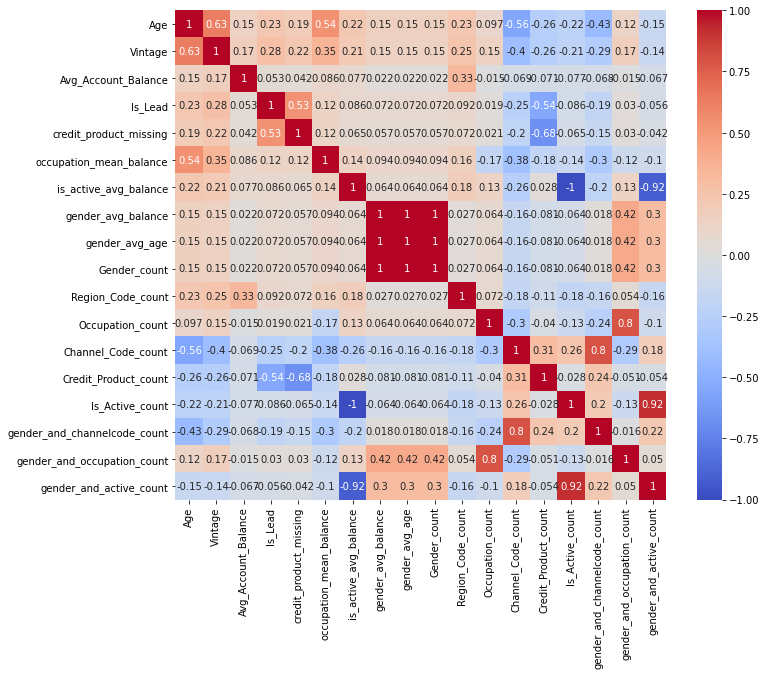

In [14]:
plt.figure(figsize=(11,9))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:
ID_COL , TARGET_COL = 'ID','Is_Lead'
features = [c for c in train_df.columns if c not in [ID_COL,TARGET_COL]]

target = train_df[TARGET_COL]

In [ ]:
train_df.to_csv('preprocessed_training.csv')

In [16]:
def run_gradient_boosting(clf, fit_params, train, test, features):
    N_SPLITS = 10
    oofs = np.zeros(len(train))
    preds = np.zeros((len(test)))

    folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        preds_test = clf.predict_proba(X_test)[:, 1]

        roc_score = roc_auc_score(y_val,preds_val)
        print("ROC for validation set is {}".format(roc_score))

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS
    
    print(oofs)
    oofs_score = roc_auc_score(target, oofs.round())
    print('ROC score for oofs is {}'.format(oofs_score))
    

    return oofs, preds

In [17]:
def evaluateModel(actual, predicted, message = "Test set"):
    print(message)
    print("F1-Score:", f1_score(actual, predicted))
    print("ROC AUC Score:", roc_auc_score(actual, predicted))
    print("Confusion Matrix:", confusion_matrix(actual, predicted))
    print('-'*100)

In [18]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
parameters = {
    'iterations': [30, 50, 100, 500],
    'eval_metric': 'auc',
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6,8,10]    
}
model = CatBoostClassifier()

In [81]:
rs = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, verbose=1)

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_distributions'

In [69]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.02,
                       rsm = 0.4,
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 300}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_df, test_df, features)

optimized_roc = roc_auc_score(target, (cb_oofs  * 1))

print(f'Optimized ROC is {optimized_roc}')


------------- Fold 1 -------------
0:	learn: 0.6763171	test: 0.6764365	best: 0.6764365 (0)	total: 236ms	remaining: 11m 48s
200:	learn: 0.3460957	test: 0.3484041	best: 0.3484041 (200)	total: 11.7s	remaining: 2m 43s
400:	learn: 0.3431638	test: 0.3460126	best: 0.3460126 (400)	total: 22.7s	remaining: 2m 26s
600:	learn: 0.3419011	test: 0.3453531	best: 0.3453531 (600)	total: 34.2s	remaining: 2m 16s
800:	learn: 0.3407026	test: 0.3449408	best: 0.3449408 (800)	total: 45.6s	remaining: 2m 5s
1000:	learn: 0.3396248	test: 0.3446849	best: 0.3446849 (1000)	total: 56.9s	remaining: 1m 53s
1200:	learn: 0.3386920	test: 0.3445993	best: 0.3445960 (1192)	total: 1m 8s	remaining: 1m 43s
1400:	learn: 0.3378235	test: 0.3445325	best: 0.3445251 (1365)	total: 1m 20s	remaining: 1m 31s
1600:	learn: 0.3369839	test: 0.3445480	best: 0.3445203 (1512)	total: 1m 31s	remaining: 1m 20s
1800:	learn: 0.3362004	test: 0.3445633	best: 0.3445203 (1512)	total: 1m 43s	remaining: 1m 8s
Stopped by overfitting detector  (300 iteratio

Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3387204861
bestIteration = 971

Shrink model to first 972 iterations.
ROC for validation set is 0.8766702329777887

------------- Fold 10 -------------
0:	learn: 0.6763357	test: 0.6763882	best: 0.6763882 (0)	total: 84.4ms	remaining: 4m 13s
200:	learn: 0.3459792	test: 0.3459386	best: 0.3459386 (200)	total: 11.9s	remaining: 2m 45s
400:	learn: 0.3432924	test: 0.3437771	best: 0.3437771 (400)	total: 23.2s	remaining: 2m 30s
600:	learn: 0.3420263	test: 0.3431670	best: 0.3431659 (599)	total: 34.9s	remaining: 2m 19s
800:	learn: 0.3408705	test: 0.3428522	best: 0.3428522 (800)	total: 47s	remaining: 2m 9s
1000:	learn: 0.3398661	test: 0.3427783	best: 0.3427620 (993)	total: 58.4s	remaining: 1m 56s
1200:	learn: 0.3389263	test: 0.3427180	best: 0.3427180 (1200)	total: 1m 10s	remaining: 1m 44s
1400:	learn: 0.3380470	test: 0.3427033	best: 0.3426968 (1387)	total: 1m 21s	remaining: 1m 33s
1600:	learn: 0.3372262	test: 0.3427040	best: 0.342

In [79]:
clf.get_all_params

<bound method CatBoost.get_all_params of <catboost.core.CatBoostClassifier object at 0x00000220C79AFE80>>

In [ ]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)


optimized_f1 = roc_auc_score(target, (xgb_oofs * 1))
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
#training LightGBM model 
clf = LGBMClassifier(n_estimators = 200,
                        learning_rate = 0.05,
                        colsample_bytree = 0.5,
                        )

fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)


optimized_roc = roc_auc_score(target, (lgb_oofs * 1))
print(f'Optimized ROC is {optimized_roc}')